<a href="https://colab.research.google.com/github/EneasDavid/predi-o_meio_transporte/blob/main/tinnyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalação de pacotes necessários
%pip install tensorflow
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn

## without using
%pip install micromlgen

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32153 sha256=eb8e55f7926d82007cbc0570f54a0d1371618c929205b2d6c5f0c7a68948e200
  Stored in directory: /root/.cache/pip/wheels/97/54/64/5d82c310920abe1be0d120313ceb9e12c88f5701f53f6ed248
Successfully built micromlgen


In [3]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv2D, Flatten, LSTM, GRU, Bidirectional
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from statsmodels.tsa.stattools import adfuller
from keras import callbacks
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os
from imutils import paths
from sklearn.utils import shuffle
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose

import psutil

# Importando datetime e math
import datetime
import time
import math

# Importando o backend do Keras
from tensorflow.keras import backend as K

In [4]:
if tf.test.is_gpu_available():
  if gpus:
    print(f"GPUs disponíveis: {gpus}.  O código pode ser otimizado para uso em GPU.")
else:
    print("GPU não está disponível. O código será executado na CPU.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU não está disponível. O código será executado na CPU.


In [5]:
cpus = tf.config.list_physical_devices('CPU')
if cpus:
    print(f"CPUs disponíveis: {cpus}. O código será executado na CPU.")
else:
    print("Nenhuma CPU disponível.")

CPUs disponíveis: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]. O código será executado na CPU.


In [6]:
## Importando acesso ao Drive com a base de dados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Quantidade de colunas em cada categoria
categories = ['Mostly Null', 'Partially Null', 'No Null']
counts = [len(mostly_null), len(partially_null), len(no_null)]

# Plotando o gráfico de barras
plt.bar(categories, counts, color=['red', 'orange', 'green'], alpha=0.7)

# Adicionando rótulos e título
plt.xlabel("Categorias")
plt.ylabel("Quantidade de Colunas")
plt.title("Distribuição das Colunas por Percentual de Valores Nulos")

# Exibindo os valores no topo das barras
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [8]:
def drop_column_by_name(df, column='id'):
    if column in df.columns:
        return df.drop(column, axis=1)
    print(f"Column '{column}' not found in the DataFrame.")

In [9]:
def remove_mostly_null_columns(df, mostly_null):
    return df.drop(mostly_null, axis=1)

In [10]:
def fill_null_with_zero(df, partially_null):
  for i in partially_null:
    df[i] = df[i].fillna(0)
  return df

In [11]:
def inspect_columns(df):
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        total_rows = len(df)
        percentage = (missing_count * 100) / total_rows

        print(f'Feature Name: {column}')
        print(f'Number of missing values: {missing_count} out of {total_rows}')
        print(f'Missing percentage: {percentage:.2f}%')
        print()

In [12]:
# Função para identificar correlações e remover colunas altamente correlacionadas
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    # corr_matrix = dataset.corr()
    # Convertendo todas as colunas para numérico, se possível, caso contrário, pula
    corr_matrix = dataset.apply(pd.to_numeric, errors='ignore').corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [33]:
def normalize_target(df):
    # Identificar valores únicos da coluna 'target'
    target_df = df['target'].unique()

    # Criar um mapeamento de valores únicos para números de 0 a len(target_df)-1
    target_map = {target: idx for idx, target in enumerate(target_df)}
    print(target_map)
    ## Mapeamento de valores para a coluna 'target'
    df['target'] = df['target'].map(target_map)

    return df, target_map

In [14]:
def drop_user(df):
   return df.drop(['user'], axis = 1)

In [15]:
def plot_confusion_matrix(model, X_test, y_test, class_names):
    # Obter as previsões do modelo
    y_pred = model.predict(X_test)

    # Se o modelo estiver retornando probabilidades, converta para rótulos
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)

    # Computar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Plotar a matriz de confusão
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.colorbar()

    # Adicionar rótulos nos eixos
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Mostrar valores na matriz de confusão
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Prevista')
    plt.tight_layout()
    plt.show()

In [16]:
def evaluate_quantization(model_path, X_test, y_test, quantization_type=None):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Avaliar o modelo quantizado
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    predictions = []
    processing_times = []

    X_test = np.array(X_test, dtype=np.float32)

    for X in X_test:
        interpreter.set_tensor(input_index, [X])

        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        output = interpreter.get_tensor(output_index)
        predictions.append(np.argmax(output[0]))

    # Calcular métricas de desempenho
    predictions = np.array(predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Calcular a média e o desvio padrão das diferenças
    result = { "MSE": mse, #Mean Squared Error
                "MAE": mae,#Mean Absolute Error
                "R2-Score": r2, #Coefficient of Determination
                "Process time": np.mean(processing_times)
            }

    return result

In [17]:
# Avaliação do modelo quantizado
def evaluate_quantization(model_path, X_test, y_test, quantization_type=None):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Avaliar o modelo quantizado
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    predictions = []
    processing_times = []

    X_test = np.array(X_test, dtype=np.float32)

    for X in X_test:
        interpreter.set_tensor(input_index, [X])

        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        output = interpreter.get_tensor(output_index)
        predictions.append(np.argmax(output[0]))

    # Calcular métricas de desempenho
    predictions = np.array(predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Calcular a média e o desvio padrão das diferenças
    result = { "MSE": mse, #Mean Squared Error
                "MAE": mae,#Mean Absolute Error
                "R2-Score": r2, #Coefficient of Determination
                "Process time": np.mean(processing_times)
            }

    return result

In [18]:
def plot_loss_and_accuracy(loss, val_loss, epochs):
    # Plotar a perda (erro de previsão) e a precisão durante o treinamento
    plt.figure(figsize=(12, 4))

    # Plotar perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plotar precisão
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisão de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
# Avaliar o modelo final
def evaluate_model(model, X_test, y_test):
  loss, accuracy=model.evaluate(X_test, y_test)
  print(f'Acurácia no teste após salvar o modelo: {accuracy}')

In [20]:
# Criar o modelo MLP (Multi-Layer Perceptron)
def create_mlp_model(X_train, y_train, X_test, y_test):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')  # 5 classes de modos de transporte
    ])

    # Compilar o modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callback para parar o treinamento se não houver melhoria
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(X_train, y_train,
                        epochs=20,  # Aumentar o número de épocas
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])  # Usar o callback

    # Salvar o modelo treinado
    model.save('/content/drive/MyDrive/Dataset/model.keras')

    return model  #

In [21]:
# Criar modelo XGbost ()
"""
******Falta fazer******
"""

'\n******Falta fazer******\n'

In [22]:
def convert_to_tflite(model, model_name='model.tflite'):
    # Converter o modelo Keras para TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Otimização do modelo
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Converter o modelo
    tflite_model = converter.convert()

    # Salvar o modelo convertido
    with open(model_name, 'wb') as f:
        f.write(tflite_model)
    return model_name

In [23]:
def predict_with_tflite(interpreter, data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Listas para armazenar as previsões e os dados de desempenho
    predictions = []
    memory_usage = []
    cpu_usage = []
    processing_time = []

    # Executar predições para cada amostra
    for sample in data:
        # Monitorar o uso de memória e CPU no início
        memory_before = psutil.virtual_memory().used / (1024 ** 2)  # Converter para MB
        cpu_before = psutil.cpu_percent(interval=0.1)  # Intervalo para medir uso de CPU
        start_time = time.time()

        # Definindo a forma de entrada
        interpreter.set_tensor(input_details[0]['index'], sample.reshape(1, -1))  # Reshape para (1, N)

        # Executando a inferência
        interpreter.invoke()

        # Obtendo as previsões
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(np.argmax(output_data))

        # Medir o tempo de processamento e o uso de memória após a inferência
        end_time = time.time()
        memory_after = psutil.virtual_memory().used / (1024 ** 2)  # Converter para MB
        cpu_after = psutil.cpu_percent(interval=0.1)  # Intervalo para medir uso de CPU

        time_taken = (end_time - start_time) * 1000  # Converter para milissegundos

        # Armazenar os dados de uso de memória, CPU e tempo de processamento, formatando para 2 casas decimais
        memory_usage.append(round(memory_after - memory_before, 2))
        cpu_usage.append(round(cpu_after - cpu_before, 2))
        processing_time.append(round(time_taken, 2))

        # Impressão dos resultados para depuração
        print(f"Uso de CPU durante o processo: {cpu_after- cpu_before:.2f}%")
        print(f"Uso de Memória RAM durante o processo: {memory_after - memory_before:.2f} MB")
        print(f"Tempo de processamento: {time_taken:.2f} ms")

    return np.array(predictions), memory_usage, cpu_usage, processing_time

In [24]:
# Função para carregar o modelo TFLite
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

In [25]:
# Função ajustada para comparar o uso de recursos com a acurácia
def plot_consumo_vs_acuracia(memory_usages, cpu_usages, processing_times, accuracies, model_size):
    # Convertendo a acurácia para valores numéricos para facilitar a comparação
    accuracies_numeric = [1 if acc else 0 for acc in accuracies]

    # Remover outliers ou ajustar limites para os valores (opcional)
    memory_usages = np.clip(memory_usages, 0, np.percentile(memory_usages, 99))
    cpu_usages = np.clip(cpu_usages, -100, 100)  # Ajustar intervalo de uso de CPU
    processing_times = np.clip(processing_times, 0, np.percentile(processing_times, 99))

    # Configuração geral do gráfico
    fig, axs = plt.subplots(3, 1, figsize=(12, 12))
    fig.suptitle(f'Model Size: {model_size:.2f} MB', fontsize=16)

    # Gráfico 1: Uso de Memória vs Acurácia
    axs[0].scatter(memory_usages, accuracies_numeric, color='blue', label='Memory Usage (MB) vs Accuracy')
    axs[0].set_title('Memory Usage vs Prediction Accuracy')
    axs[0].set_xlabel('Memory Usage (MB)')
    axs[0].set_ylabel('Accuracy (1=True, 0=False)')
    axs[0].grid(True)
    axs[0].legend()

    # Gráfico 2: Uso de CPU vs Acurácia
    axs[1].scatter(cpu_usages, accuracies_numeric, color='orange', label='CPU Usage (%) vs Accuracy')
    axs[1].set_title('CPU Usage vs Prediction Accuracy')
    axs[1].set_xlabel('CPU Usage (%)')
    axs[1].set_ylabel('Accuracy (1=True, 0=False)')
    axs[1].grid(True)
    axs[1].legend()

    # Gráfico 3: Tempo de Processamento vs Acurácia
    axs[2].scatter(processing_times, accuracies_numeric, color='green', label='Processing Time (ms) vs Accuracy')
    axs[2].set_title('Processing Time vs Prediction Accuracy')
    axs[2].set_xlabel('Processing Time (ms)')
    axs[2].set_ylabel('Accuracy (1=True, 0=False)')
    axs[2].grid(True)
    axs[2].legend()

    # Ajuste do layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [46]:
def grafico_classificacao(mostly_null, partially_null, no_null):
    # Quantidade de colunas em cada categoria
    categories = ['Mostly Null', 'Partially Null', 'No Null']
    counts = [len(mostly_null), len(partially_null), len(no_null)]

    # Plotando o gráfico de barras
    plt.bar(categories, counts, color=['red', 'orange', 'green'], alpha=0.7)

    # Adicionando rótulos e título
    plt.xlabel("Categorias")
    plt.ylabel("Quantidade de Colunas")
    plt.title("Distribuição das Colunas por Percentual de Valores Nulos")

    # Exibindo os valores no topo das barras
    for i, count in enumerate(counts):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

    plt.show()

In [47]:
# Carregar os dados
df_origin = pd.read_csv('/content/drive/MyDrive/Dataset/dataset_5secondWindow.csv')
# Exibir primeiras cinco linhas do dataset
df=df_origin.copy()
df.head()

,id,time,activityrecognition#0,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#min,...,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,speed#std,target,user
0,16170,78,NaN,100,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,U12
1,15871,145,NaN,100,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,...,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,0.628595,Car,U12
2,16811,150,NaN,100,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,Still,U12
3,15831,105,NaN,77,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,...,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,0.628595,Car,U12
4,876,77,NaN,100,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,...,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,NaN,Car,U1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5893 entries, 0 to 5892
Data columns (total 70 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               5893 non-null   int64  
 1   time                                             5893 non-null   int64  
 2   activityrecognition#0                            0 non-null      float64
 3   activityrecognition#1                            5893 non-null   int64  
 4   android.sensor.accelerometer#mean                5893 non-null   float64
 5   android.sensor.accelerometer#min                 5893 non-null   float64
 6   android.sensor.accelerometer#max                 5893 non-null   float64
 7   android.sensor.accelerometer#std                 5893 non-null   float64
 8   android.sensor.game_rotation_vector#mean         5094 non-null   float64
 9   android.sensor.game_rotation_v

In [48]:
## cria um array para receber os nomes das colunas que não tem atributos
mostly_null = []

## cria um array para receber os nomes das colunas com valores parcialmente nulos
partially_null = []

## cria um array para receber os nomes das colunas sem valores nulos
no_null = []


# Etapa 1: Categorizar as colunas
mostly_null, partially_null, no_null = categorize_columns_by_nulls(df)

Feature Name: id
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: time
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: activityrecognition#0
Number of missing values: 5893 out of 5893
Missing percentage: 100.00%

Feature Name: activityrecognition#1
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#mean
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#min
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#max
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#std
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.game_rotation_vector#mean
Number of missing values: 799 out of 5893
Missing percentage: 13.56%

Feature Name: android.sensor.game_rot

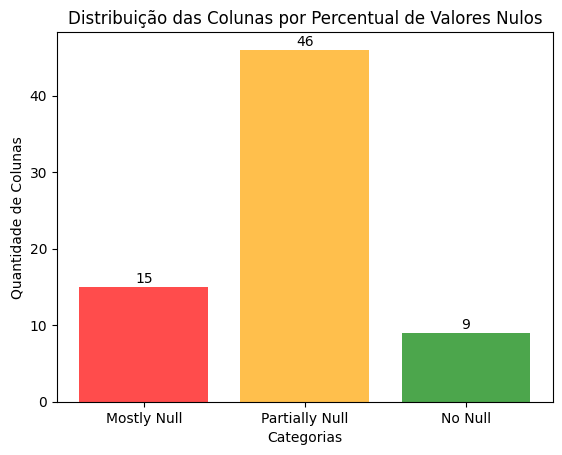

In [50]:
grafico_classificacao(mostly_null, partially_null, no_null)

In [51]:
# Etapa 2: Remover colunas com valores nulos em sua maioria
df=remove_mostly_null_columns(df, mostly_null)
df.head()

,id,time,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#min,android.sensor.game_rotation_vector#max,...,android.sensor.rotation_vector#std,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,target,user
0,16170,78,100,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,...,0.002109,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Still,U12
1,15871,145,100,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,...,0.000026,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,Car,U12
2,16811,150,100,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,...,0.011312,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Still,U12
3,15831,105,77,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,...,0.002788,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,Car,U12
4,876,77,100,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,...,0.025608,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,Car,U1


In [52]:
# Etapa 3: Remover coluna 'id' (ou qualquer outra especificada)
df = drop_column_by_name(df)
df.head()

,time,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#min,android.sensor.game_rotation_vector#max,android.sensor.game_rotation_vector#std,...,android.sensor.rotation_vector#std,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,target,user
0,78,100,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,0.000119,...,0.002109,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Still,U12
1,145,100,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,...,0.000026,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,Car,U12
2,150,100,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,0.000004,...,0.011312,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Still,U12
3,105,77,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,...,0.002788,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,Car,U12
4,77,100,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,...,0.025608,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,Car,U1


In [53]:
# Etapa 4: Preencher os valores nulos parciais com zero
"""
Zerei por as colunas em especifico não acarrentam tanto assim na predição
"""
df = fill_null_with_zero(df, partially_null)
df.head()

,time,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#min,android.sensor.game_rotation_vector#max,android.sensor.game_rotation_vector#std,...,android.sensor.rotation_vector#std,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,target,user
0,78,100,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,0.000119,...,0.002109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Still,U12
1,145,100,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,...,0.000026,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,Car,U12
2,150,100,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,0.000004,...,0.011312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Still,U12
3,105,77,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,...,0.002788,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,Car,U12
4,77,100,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,...,0.025608,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,Car,U1


In [54]:
# Etapa 5: Inspecionar as colunas para verificar se ainda há valores nulos
mostly_null, partially_null, no_null = categorize_columns_by_nulls(df)

Feature Name: time
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: activityrecognition#1
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#mean
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#min
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#max
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.accelerometer#std
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.game_rotation_vector#mean
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.game_rotation_vector#min
Number of missing values: 0 out of 5893
Missing percentage: 0.00%

Feature Name: android.sensor.game_rotation_vector#max
Number of missing values: 0 out of 5893
Missing percentag

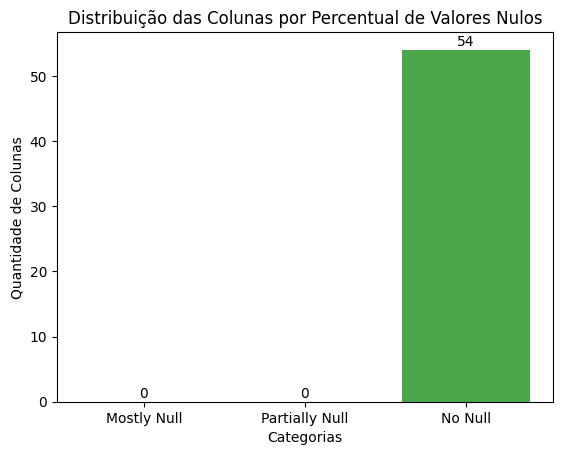

In [55]:
grafico_classificacao(mostly_null, partially_null, no_null)

In [58]:
# Mapeamento de valores para a coluna 'target'
df, target_normalizado=normalize_target(df)
print(target_normalizado)
df.head()

{'Still': 0, 'Car': 1, 'Train': 2, 'Bus': 3, 'Walking': 4}
{'Still': 0, 'Car': 1, 'Train': 2, 'Bus': 3, 'Walking': 4}


,time,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#min,android.sensor.game_rotation_vector#max,android.sensor.game_rotation_vector#std,...,android.sensor.rotation_vector#max,android.sensor.rotation_vector#std,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,target
0,78,100,9.811476,9.758895,9.849411,0.014626,0.029340,0.029014,0.029526,0.000119,...,0.056351,0.002109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,145,100,9.939207,7.707437,17.146631,1.775944,0.999925,0.999903,0.999946,0.000030,...,0.999999,0.000026,89.200210,89.065143,89.335277,0.191013,16.539349,16.539349,16.539349,1
2,150,100,9.827178,9.804817,9.849262,0.011199,0.665215,0.665213,0.665218,0.000004,...,0.610456,0.011312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,105,77,9.673039,7.659674,12.304298,0.862553,0.996221,0.993781,0.998661,0.003451,...,0.998112,0.002788,87.470377,87.470377,87.470377,2.284186,17.739895,17.739895,17.739895,1
4,77,100,9.993466,8.965621,10.891645,0.504117,0.563792,0.521799,0.672664,0.064792,...,0.378193,0.025608,89.770732,89.770732,89.770732,0.006389,9.000000,9.000000,9.000000,1


In [57]:
## Exclui os valores da coluna user, pois não é necessario para o modelo
df =drop_user(df)

In [62]:
# Identificar features altamente correlacionadas e removê-las
threshold = 0.7
corr_features = correlation(df, threshold)

<ipython-input-12-17d68f11f606>:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  corr_matrix = dataset.apply(pd.to_numeric, errors='ignore').corr()


In [68]:
# Calculando correlação antes da remoção
corr_matrix_before = df.apply(pd.to_numeric, errors='ignore').corr()

# Criando novo DataFrame sem as colunas correlacionadas
df_after = df.drop(columns=corr_features)

# Calculando correlação depois da remoção
corr_matrix_after = df_after.apply(pd.to_numeric, errors='ignore').corr()

<ipython-input-68-0640390d14c1>:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  corr_matrix_before = df.apply(pd.to_numeric, errors='ignore').corr()
<ipython-input-68-0640390d14c1>:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  corr_matrix_after = df_after.apply(pd.to_numeric, errors='ignore').corr()


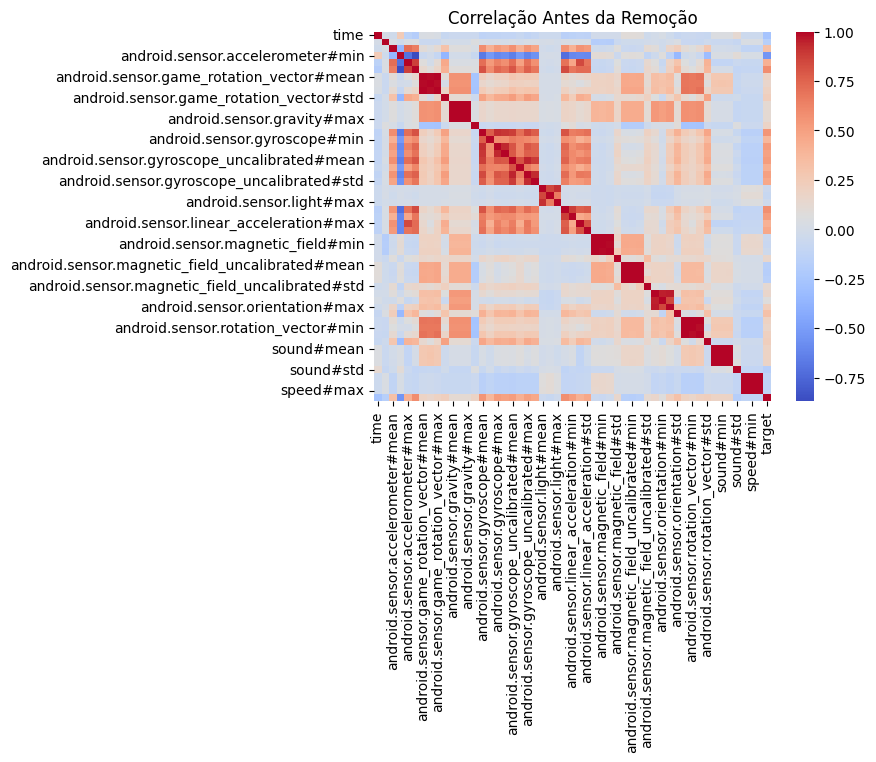

In [73]:
# Plotando a matriz de correlação antes da remoção
sns.heatmap(corr_matrix_before, annot=False, cmap="coolwarm")
plt.title("Correlação Antes da Remoção")
plt.show()

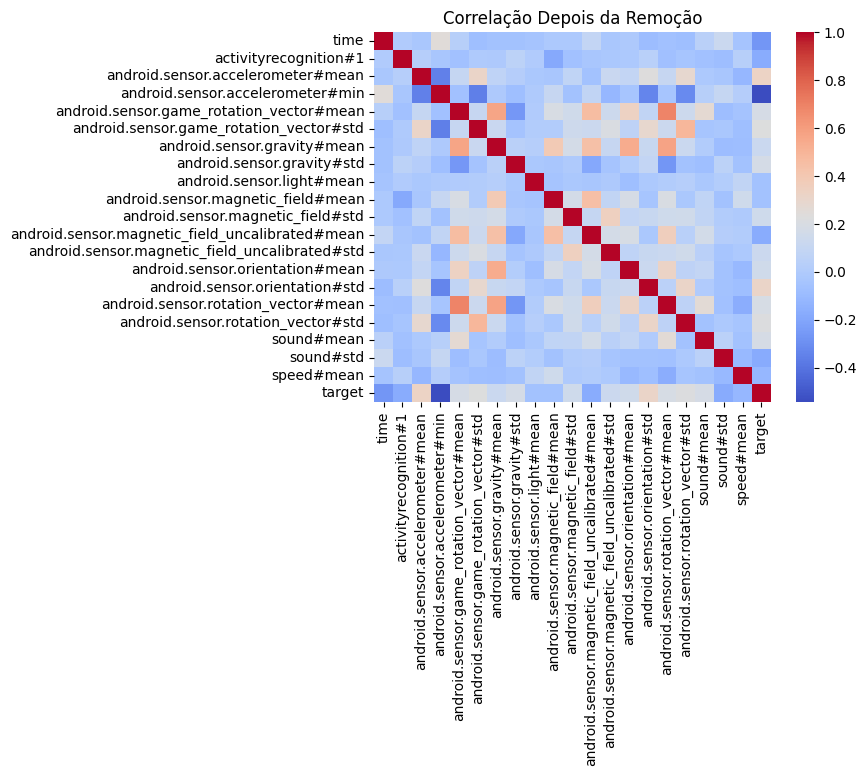

In [74]:
# Plotando a matriz de correlação depois da remoção
sns.heatmap(corr_matrix_after, annot=False, cmap="coolwarm")
plt.title("Correlação Depois da Remoção")
plt.show()

In [ ]:
df = df.drop(corr_features, axis=1)

In [ ]:
df.describe()

,time,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.game_rotation_vector#mean,android.sensor.game_rotation_vector#std,android.sensor.gravity#mean,android.sensor.gravity#std,android.sensor.light#mean,android.sensor.magnetic_field#mean,...,android.sensor.magnetic_field_uncalibrated#mean,android.sensor.magnetic_field_uncalibrated#std,android.sensor.orientation#mean,android.sensor.orientation#std,android.sensor.rotation_vector#mean,android.sensor.rotation_vector#std,sound#mean,sound#std,speed#mean,target
count,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5.893000e+03,5893.000000,5893.000000,...,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000,5893.000000
mean,117.731716,87.718310,10.007976,8.426262,0.656334,0.010264,8.979501,1.109186e-04,214.719958,51.509849,...,119.642929,1.759568,194.697017,11.386287,0.672221,0.011369,65.445964,1.318661,4.919072,1.998982
std,126.474151,24.562728,0.655949,1.783007,0.349446,0.025104,2.725407,7.331068e-04,1524.050996,39.750684,...,81.285151,5.087477,108.627233,30.302779,0.351982,0.027480,32.136026,2.871450,10.023778,1.414093
min,3.000000,3.000000,7.369055,0.337166,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,90.000000,9.737143,7.805295,0.443915,0.000073,9.806639,2.620000e-07,0.000000,33.718130,...,66.060126,0.239259,118.056635,0.121199,0.389736,0.000125,58.402467,0.000000,0.000000,1.000000
50%,70.000000,100.000000,9.850143,9.123124,0.779667,0.001083,9.806650,4.140000e-07,4.500000,43.986134,...,123.533304,0.823157,200.344560,0.942900,0.813465,0.002157,79.475484,0.037179,0.000000,2.000000
75%,152.000000,100.000000,10.078998,9.691731,0.956667,0.007644,9.806650,1.170000e-06,56.000000,57.166892,...,156.032977,1.880690,289.619711,5.587991,0.967870,0.009687,89.722940,1.487859,5.250000,3.000000
max,682.000000,100.000000,17.427391,12.115013,1.000000,0.324466,9.822576,1.032261e-02,75315.500000,679.430960,...,728.981987,322.963637,403.489790,245.421004,1.000000,0.439629,90.308734,26.835546,51.360060,4.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5893 entries, 0 to 5892
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   time                                             5893 non-null   int64  
 1   activityrecognition#1                            5893 non-null   int64  
 2   android.sensor.accelerometer#mean                5893 non-null   float64
 3   android.sensor.accelerometer#min                 5893 non-null   float64
 4   android.sensor.game_rotation_vector#mean         5893 non-null   float64
 5   android.sensor.game_rotation_vector#std          5893 non-null   float64
 6   android.sensor.gravity#mean                      5893 non-null   float64
 7   android.sensor.gravity#std                       5893 non-null   float64
 8   android.sensor.light#mean                        5893 non-null   float64
 9   android.sensor.magnetic_field#

In [ ]:
# Selecione as colunas relevantes para as features (entradas) e o alvo (saída)
X = df[['android.sensor.accelerometer#mean',
        'android.sensor.accelerometer#min',
        'speed#mean',
        'android.sensor.gravity#mean',
        'android.sensor.gravity#std',
        'android.sensor.game_rotation_vector#mean',
        'android.sensor.game_rotation_vector#std',
        'android.sensor.magnetic_field#mean',
        'android.sensor.magnetic_field#std',
        'android.sensor.orientation#mean',
        'android.sensor.orientation#std',
        'sound#mean',
        'sound#std']]  # Incluindo as novas colunas relevantes

y = df['target']  # Coluna alvo (modos de transporte)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

"""
    Função para aplicar o KMeans em um dataframe e gerar gráficos de dispersão com PCA para visualização.

    Parâmetros:
    - df: DataFrame com os dados
    - X_columns: Lista de colunas do DataFrame para X (features)
    - y_column: Nome da coluna alvo (target)
    - n_clusters: Número de clusters para o KMeans
    - pca_components: Número de componentes principais para o PCA (default 2)
"""

# Separação de features e alvo
    X = df[X_columns]
    y = df[y_column]

    # Aplicar PCA para reduzir a dimensionalidade para 2D (para visualização)
    pca = PCA(n_components=pca_components)
    X_pca = pca.fit_transform(X)

    # Aplicar KMeans com o número de clusters especificado
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Plotar os clusters
    plt.figure(figsize=(20, 10))

    # Subplot para Dispersão Original
    plt.subplot(1, 2, 1)
    plt.title("Dispersão Original")
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', style=y_kmeans,
                    markers=['o', 's', 'D', '^', 'v'], s=100, edgecolor='black')
    plt.xlabel('Componente Principal 1', fontsize=14)
    plt.ylabel('Componente Principal 2', fontsize=14)

    # Subplot para Dispersão com K-means
    plt.subplot(1, 2, 2)
    plt.title("Dispersão com K-means")
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_kmeans, palette='viridis', style=y,
                    markers=['o', 's', 'D', '^', 'v'], s=100, edgecolor='black')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
    plt.xlabel('Componente Principal 1', fontsize=14)
    plt.ylabel('Componente Principal 2', fontsize=14)

    # Melhorando a legenda
    handles, labels = plt.gca().get_legend_handles_labels()

    # Legenda para os clusters (cores)
    cluster_labels = [f'Cluster {i}' for i in range(n_clusters)]
    cluster_legend = plt.legend(handles[:n_clusters], cluster_labels, title='Clusters', loc='upper right', fontsize=12)

    # Legenda para os modos de transporte reais (marcadores)
    mode_labels = ['Still', 'Car', 'Train', 'Bus', 'Walking']  # Substitua com os rótulos reais, se necessário
    mode_legend = plt.legend(handles[n_clusters:], mode_labels, title='Modos de Transporte', loc='lower right', fontsize=12)

    # Exibindo as duas legendas no gráfico
    plt.gca().add_artist(cluster_legend)
    plt.gca().add_artist(mode_legend)

    # Exibir o gráfico
    plt.grid(True)
    plt.show()

# Exemplo de uso da função
# Certifique-se de ter um DataFrame com as colunas corretas para as variáveis X e y
# plot_kmeans_clusters(df, ['android.sensor.accelerometer#mean', 'android.sensor.accelerometer#min', 'speed#mean'], 'target')

IndentationError: unexpected indent (<ipython-input-55-c7d720033ab4>, line 4)

In [ ]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model=create_mlp_model(X_train, y_train, X_test, y_test)
evaluate_model(model, X_test, y_test)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4599 - loss: 1.3372 - val_accuracy: 0.6319 - val_loss: 0.9979
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5914 - loss: 1.0310 - val_accuracy: 0.6421 - val_loss: 0.9192
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6136 - loss: 0.9713 - val_accuracy: 0.6751 - val_loss: 0.8786
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6307 - loss: 0.9315 - val_accuracy: 0.6387 - val_loss: 0.8762
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6218 - loss: 0.9225 - val_accuracy: 0.6751 - val_loss: 0.8426
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6557 - loss: 0.8853 - val_accuracy: 0.6404 - val_loss: 0.8437
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6561 - loss: 0.8493 - val_accuracy: 0.6751 - val_loss: 0.8213
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6531 - loss: 0.8781 - val_accuracy: 0.6904 - val_

In [ ]:
# Obter histórico de perda para treinamento e validação
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

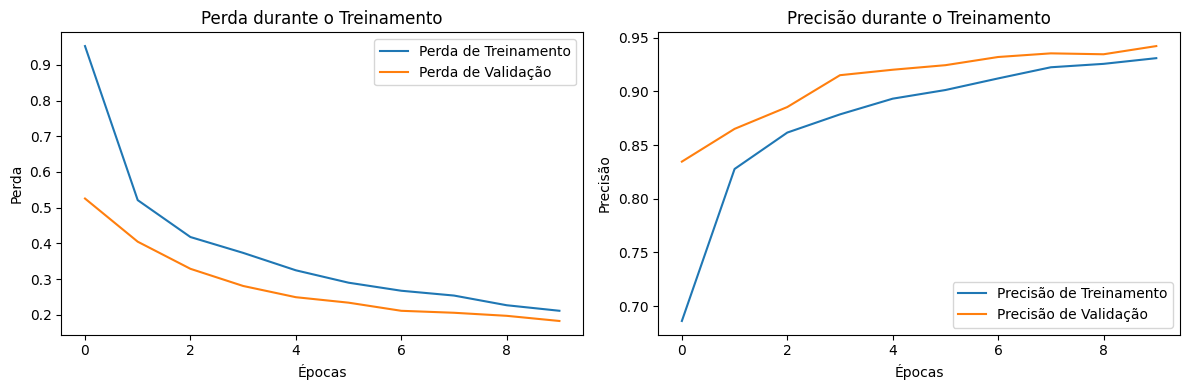

In [ ]:
plot_loss_and_accuracy(loss, val_loss, epochs)

In [ ]:
# Avaliar o modelo final
evaluate_model(model, X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9385 - loss: 0.1970 
Acurácia no teste após salvar o modelo: 0.9423239827156067


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


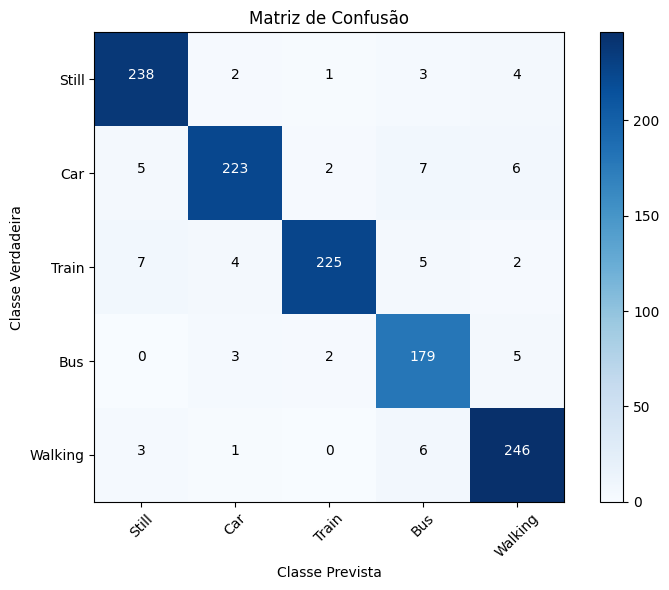

In [ ]:
plot_confusion_matrix(model, X_test, y_test, target_normalizado)

In [ ]:
model_mlp_path=convert_to_tflite(model, 'mlp_model.tflite')

Saved artifact at '/tmp/tmpli0tl8zq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139763315662640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315666160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315662288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315668096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315658944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315669680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315657536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139763315666688: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Nomes das características
feature_names = list(df.columns[:-1])  # Excluir a coluna 'target'

# Carregar o modelo TFLite
interpreter = load_tflite_model(model_mlp_path)

# Dados fornecidos
data = np.array(X_test[:100], dtype=np.float32)  # Apenas os primeiros 100 dados
result_test_esperado = np.array(y_test[:100])
# Realizar predições para o conjunto de teste
predictions, memory_usage, cpu_usage, processing_time = predict_with_tflite(interpreter, data)
# Calcular a acurácia
accuracies = []  # Inicializa a lista para armazenar as acurácias
for i in range(len(predictions)):
    accuracies.append(result_test_esperado[i] == predictions[i])  # Adiciona o resultado da comparação

# Opcional: calcular a porcentagem de acertos
accuracy_percentage = np.mean(accuracies) * 100

Uso de CPU durante o processo: -5.00%
Uso de Memória RAM durante o processo: 0.00 MB
Tempo de processamento: 0.10 ms
Uso de CPU durante o processo: -5.00%
Uso de Memória RAM durante o processo: 0.00 MB
Tempo de processamento: 0.09 ms
Uso de CPU durante o processo: 5.00%
Uso de Memória RAM durante o processo: 0.00 MB
Tempo de processamento: 0.09 ms
Uso de CPU durante o processo: 52.90%
Uso de Memória RAM durante o processo: 0.00 MB
Tempo de processamento: 0.09 ms
Uso de CPU durante o processo: 2.40%
Uso de Memória RAM durante o processo: 1.72 MB
Tempo de processamento: 0.11 ms
Uso de CPU durante o processo: 7.40%
Uso de Memória RAM durante o processo: 0.00 MB
Tempo de processamento: 0.11 ms
Uso de CPU durante o processo: -2.60%
Uso de Memória RAM durante o processo: -0.00 MB
Tempo de processamento: 0.10 ms
Uso de CPU durante o processo: 10.00%
Uso de Memória RAM durante o processo: 10.34 MB
Tempo de processamento: 0.13 ms
Uso de CPU durante o processo: 3.20%
Uso de Memória RAM durante o

Uso da memória: [0.0, 0.0, 0.0, 0.0, 1.72, 0.0, -0.0, 10.34, 0.0, 0.0, 4.43, 0.0, 11.32, 0.0, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -31.14, -0.0, 0.0, 0.0, 0.0, 0.74, -0.0, 0.0, 0.0, -0.01, 0.25, 0.0, 0.0, -0.04, 0.0, 0.25]
Uso da CPU: [-5.0, -5.0, 5.0, 52.9, 2.4, 7.4, -2.6, 10.0, 3.2, -2.1, 6.9, 5.0, -11.3, 1.6, 15.0, -1.3, 0.0, -20.5, 10.0, 0.0, -5.0, 0.5, 5.0, 0.5, -5.3, 4.5, 0.0, -5.0, 5.0, 9.5, 4.8, 0.0, 4.8, 10.0, 10.0, 5.0, 10.0, -5.0, 4.8, 4.8, 9.5, -4.8, 4.8, 14.3, -0.2, -5.3, -5.0, -30.2, 14.3, -0.5, 5.0, -4.5, 5.0, -4.8, -14.3, -10.5, 5.0, -5.0, 5.0, -10.5, -5.0, -9.5, 4.8, 0.0, -1.0, -5.0, 42.4, 7.9, -2.4, -7.1, 1.9, -4.0, -5.0, -10.0, -5.9, -2.2, 3.1, 2.2, -3.5,

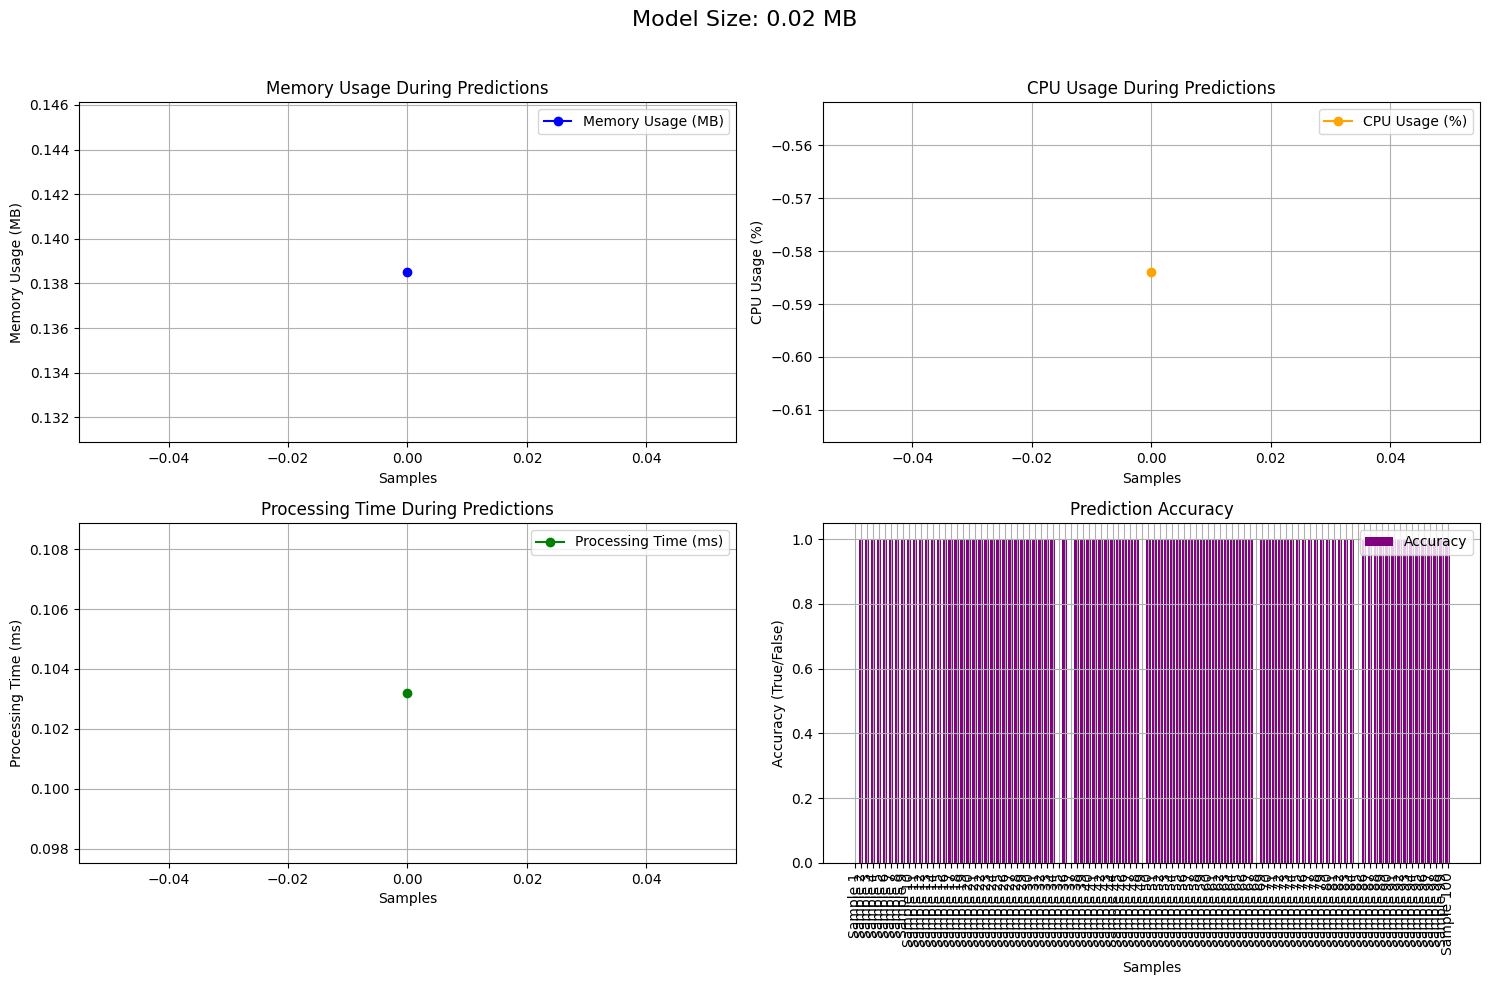

In [ ]:
# Utilização da função com os valores coletados
model_size = os.path.getsize(model_mlp_path) / (1024 ** 2)

print(f"Uso da memória: {memory_usage}")
print(f"Uso da CPU: {cpu_usage}")
print(f"Tamanho do modelo: {model_size:.2f} MB")  # Formatação para duas casas decimais
print(f"Acurácias: {accuracies}")
print(f"Tempo de processamento: {processing_time}")

# Chamar a função para plotar os gráficos
plot_consumo_recursos(memory_usages, cpu_usages, processing_times, accuracies, model_size)

Base de dados co